In [ ]:
# ⚙️ Preparación de entorno y rutas
# Si esta celda tarda demasiado o se cuelga:
# 1) Abre la paleta de comandos (Ctrl+Shift+P)
# 2) "Jupyter: Restart Kernel"
# 3) "Run All Above/Below" o ejecuta desde la primera celda

import sys
from pathlib import Path

# Detectar raíz del repo (buscando pyproject.toml o carpeta src)
_candidates = [Path.cwd(), *Path.cwd().parents]
_repo_root = None
for _p in _candidates:
    if (_p / 'pyproject.toml').exists() or (_p / 'src').exists():
        _repo_root = _p
        break
if _repo_root is None:
    _repo_root = Path.cwd()

if str(_repo_root) not in sys.path:
    sys.path.insert(0, str(_repo_root))

print(f"✅ Entorno listo. Raíz del repo: {_repo_root}")

# Si9: Flujo técnico end-to-end
Este notebook implementa el flujo 'Si9' con carga de datos, preprocesamiento, un algoritmo base, evaluación de métricas, pruebas y visualización/exportación.

# 1) Configurar entorno y dependencias
Instalar y verificar versiones; configurar semilla para reproducibilidad.

In [1]:
import sys, platform, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc)
from sklearn.impute import SimpleImputer
import joblib

np.random.seed(42)
print(f"Python: {platform.python_version()} | NumPy: {np.__version__} | pandas: {pd.__version__}")

Python: 3.10.0 | NumPy: 2.2.6 | pandas: 2.3.3


# 2) Cargar datos Si9
Leer datos desde CSV (o API). Se validan encabezados y tipos; manejo de errores con try/except.

In [2]:
from pathlib import Path

data_path = Path("data/raw/si9_dataset.csv")
expected_cols = ["feature_num1", "feature_num2", "feature_cat", "target"]

try:
    if data_path.exists():
        df = pd.read_csv(data_path)
        print(f"Cargado CSV: {data_path} | shape={df.shape}")
    else:
        # Generar dataset sintético si no existe
        n = 1000
        df = pd.DataFrame({
            "feature_num1": np.random.normal(0, 1, n),
            "feature_num2": np.random.uniform(-5, 5, n),
            "feature_cat": np.random.choice(["A", "B", "C"], size=n),
            "target": np.random.choice([0, 1], size=n, p=[0.6, 0.4])
        })
        print("Dataset sintético generado (si9)")
    # Validar columnas
    missing = [c for c in expected_cols if c not in df.columns]
    if missing:
        raise ValueError(f"Faltan columnas: {missing}")
    # Tipos básicos
    print(df.dtypes)
except Exception as e:
    print(f"Error al cargar/validar datos: {e}")
    raise

Dataset sintético generado (si9)
feature_num1    float64
feature_num2    float64
feature_cat      object
target            int64
dtype: object


# 3) Preprocesamiento de Si9
Limpiar nulos, normalizar numéricas y codificar categóricas. Dividir train/test.

In [3]:
# Separar X/y
X = df.drop(columns=["target"])
y = df["target"]

num_features = ["feature_num1", "feature_num2"]
cat_features = ["feature_cat"]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features),
    ]
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print(X_train.shape, X_test.shape)

(800, 3) (200, 3)


# 4) Algoritmo base de Si9
Entrenar un modelo rápido (LogisticRegression) y un baseline (DummyClassifier). Guardar el modelo con joblib.

In [4]:
model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", LogisticRegression(max_iter=500, n_jobs=None))
])

baseline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", DummyClassifier(strategy="most_frequent"))
])

t0 = time.time()
model.fit(X_train, y_train)
t_model = time.time() - t0
t0 = time.time()
baseline.fit(X_train, y_train)
t_base = time.time() - t0
print(f"Entrenamiento LogisticRegression: {t_model:.3f}s | Baseline: {t_base:.3f}s")

# Guardar modelo
Path("models").mkdir(parents=True, exist_ok=True)
joblib.dump(model, "models/si9_logreg.joblib")

Entrenamiento LogisticRegression: 0.016s | Baseline: 0.009s


['models/si9_logreg.joblib']

# 5) Evaluación de métricas ($Acc = \frac{TP+TN}{TP+TN+FP+FN}$)
Calcular accuracy, precision, recall y f1; matriz de confusión y curva ROC.

[LogReg] acc=0.580 prec=0.000 rec=0.000 f1=0.000
[Baseline] acc=0.590 prec=0.000 rec=0.000 f1=0.000


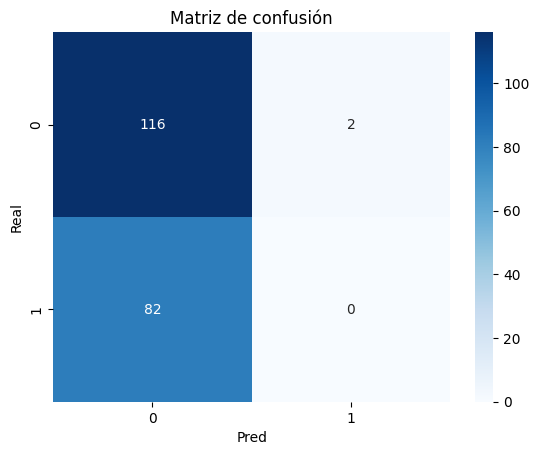

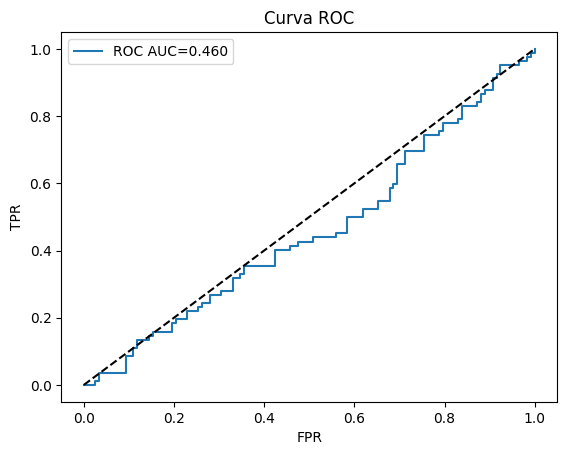

In [5]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]
y_pred_base = baseline.predict(X_test)

def report_metrics(y_true, y_hat, label):
    acc = accuracy_score(y_true, y_hat)
    prec = precision_score(y_true, y_hat, zero_division=0)
    rec = recall_score(y_true, y_hat, zero_division=0)
    f1 = f1_score(y_true, y_hat, zero_division=0)
    print(f"[{label}] acc={acc:.3f} prec={prec:.3f} rec={rec:.3f} f1={f1:.3f}")
    return acc, prec, rec, f1

_ = report_metrics(y_test, y_pred, "LogReg")
_ = report_metrics(y_test, y_pred_base, "Baseline")

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues"); plt.title("Matriz de confusión"); plt.xlabel("Pred"); plt.ylabel("Real"); plt.show()

fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(); plt.plot(fpr, tpr, label=f"ROC AUC={roc_auc:.3f}"); plt.plot([0,1],[0,1],'k--'); plt.xlabel('FPR'); plt.ylabel('TPR'); plt.legend(); plt.title('Curva ROC'); plt.show()

# 6) Pruebas unitarias en VS Code (integración)
Crear tests con `pytest` o `unittest` para validar carga, preprocesamiento y predicción; configurar detección en VS Code y ejecutar en el panel de Pruebas.

In [ ]:
# Ejemplo rápido de prueba con unittest (se puede mover a tests/):
import unittest

class TestSi9(unittest.TestCase):
    def test_model_predict_shape(self):
        preds = model.predict(X_test)
        self.assertEqual(len(preds), len(y_test))

suite = unittest.TestLoader().loadTestsFromTestCase(TestSi9)
unittest.TextTestRunner(verbosity=2).run(suite)

# 7) Visualización y exportación de resultados
Graficar distribuciones e importancia de características; exportar métricas y predicciones a CSV/JSON.

In [ ]:
# Distribuciones de variables numéricas
fig, axs = plt.subplots(1, 2, figsize=(10,4))
sns.histplot(df["feature_num1"], ax=axs[0], kde=True); axs[0].set_title("feature_num1")
sns.histplot(df["feature_num2"], ax=axs[1], kde=True); axs[1].set_title("feature_num2")
plt.tight_layout(); plt.show()

# Importancia de características (coeficientes tras preprocesamiento)
# Nota: Los coeficientes corresponden a features transformadas; se muestra tamaño absoluto como proxy.
model_clf = model.named_steps["clf"]
print("Coeficientes (abs):", np.abs(model_clf.coef_).sum())

# Exportación de métricas y predicciones
metrics = pd.DataFrame({
    "metric": ["acc", "prec", "rec", "f1"],
    "logreg": list(report_metrics(y_test, y_pred, "LogReg")),
    "baseline": list(report_metrics(y_test, y_pred_base, "Baseline"))
})
preds_out = pd.DataFrame({"y_true": y_test, "y_pred": y_pred, "y_proba": y_proba})
Path("outputs").mkdir(parents=True, exist_ok=True)
metrics.to_csv("outputs/si9_metrics.csv", index=False)
preds_out.to_csv("outputs/si9_predictions.csv", index=False)
print("Exportados outputs/si9_metrics.csv y outputs/si9_predictions.csv")